In [47]:
import numpy as np
from numpy.random import randint
import pandas as pd
import matplotlib.pyplot as plt

#### The model training process
1.	Data Splitting:
After feature aggregation, we obtain the final data frame for model building with the cardID index provided from the Kaggle training set. We first split the data set into 80% and 20% as a new data set and validation set. Then for the new data set, we further split it into 80% and 20% as the training set and the testing set.
2.	Model tuning:
For the optimal model, apply 5 folds cross-validation on the training set to tune the parameters to find the optimal model.
3.	Optimal model:
Report its average re-substitution estimate error on the training set
4.	Testing:
Test the optimal model on the testing set with 5 folds cross-validation to obtain generalization estimate error
5.	Final model selection:
Select the final model based on the average performance on the testing set. 



#### import data

In [48]:
x=pd.read_csv('[No transform]full_tb_x.csv',index_col='Unnamed: 0')
y=pd.read_csv('full_tb_y.csv',index_col='Unnamed: 0')

In [49]:
#competition submission test file
val=pd.read_csv('[testing]full_tb_x.csv',index_col='Unnamed: 0')

In [50]:
x[['feature_1', 'feature_2', 'feature_3','first_active_month_year_lag_to_reference_date']]=x[['feature_1', 'feature_2', 'feature_3','first_active_month_year_lag_to_reference_date']].astype({'feature_1':'category', 'feature_2':'category', 'feature_3':'category','first_active_month_year_lag_to_reference_date':'category'})
val[['feature_1', 'feature_2', 'feature_3','first_active_month_year_lag_to_reference_date']]=val[['feature_1', 'feature_2', 'feature_3','first_active_month_year_lag_to_reference_date']].astype({'feature_1':'category', 'feature_2':'category', 'feature_3':'category','first_active_month_year_lag_to_reference_date':'category'})

In [51]:
#split the the data
from sklearn.model_selection import train_test_split

x.set_index('card_id',inplace=True)
y.set_index('card_id',inplace=True)
val.set_index('card_id',inplace=True)

In [ ]:
X_train, X_test, Y_train, Y_test=train_test_split(x,y,test_size=0.2, random_state=100)

#### tree based baseline regression model

In [9]:
import lightgbm as lgb

from sklearn.metrics import mean_squared_error
def rmse(actual,predict): 
    return (np.sqrt(mean_squared_error(actual,predict)))

In [ ]:
score1={}
num_round=5000
lgb_train = lgb.Dataset(X_train, Y_train)
lgb_test = lgb.Dataset(X_test, Y_test, reference=lgb_train)

for i in range(2,50,1):
    core_params = {
        'objective': 'regression',
        "boosting_type":"gbdt",

        "num_leaves":i,
        "min_data_in_leaf":30*i, #int(len(X_train)*(2*i/1600))
        "feature_fraction":0.8,
        "metric":"rmse"}
    bst_model = lgb.train(core_params,lgb_train,num_round,valid_sets=(lgb_test),early_stopping_rounds=50)
    y_hat=bst_model.predict(X_test,num_iteration=bst_model.best_iteration)
    score1[i]=rmse(Y_test,y_hat)

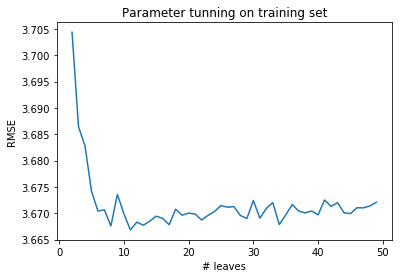

In [25]:
import matplotlib.pyplot as plt
plt.plot([i for i in score1.keys()],[i for i in score1.values()])
plt.xlabel('# leaves')
plt.ylabel('RMSE')
plt.title('Parameter tunning on training set')
plt.show()

#### K fold validation

In [289]:
# K fold function

from sklearn.model_selection import KFold

def get_oof(x, y, fold):
    NFOLDS=fold

    kf = KFold(n_splits=NFOLDS, shuffle=True)
      
    lgbm_params = core_params
    
    fold_error={}
    xval_err = 0
    for i, (train_index, test_index) in enumerate(kf.split(x)):
        #print('\nFold {}'.format(i))
        x_tr = x.loc[train_index]
        x_te = x.loc[test_index]
        
        y_tr = y.loc[train_index]
        y_te = y.loc[test_index]
        
        lgtrain = lgb.Dataset(x_tr, y_tr)
                    #feature_name=x_train.columns.tolist())
        lgvalid = lgb.Dataset(x_te, y_te, reference=lgtrain)
                    #feature_name=x_train.columns.tolist())
                    #categorical_feature = categorical)
        lgb_clf = lgb.train(
            lgbm_params,
            lgtrain,
            num_boost_round=5000,
            valid_sets=[lgvalid],
            valid_names=['valid'],
            early_stopping_rounds=50,
            verbose_eval=0
        )
        y_hat = lgb_clf.predict(x_te,num_iteration=lgb_clf.best_iteration)
        xval_err += rmse(y.loc[test_index],y_hat)
        fold_error[i]=rmse(y.loc[test_index],y_hat)
        
    cv_fold_mean_score = xval_err / NFOLDS
    return cv_fold_mean_score,fold_error

In [70]:
data_x=X_new_train.reset_index()
data_x.drop(['card_id'],axis=1,inplace=True)


data_y=Y_new_train.reset_index()
data_y.drop(['card_id'],axis=1,inplace=True)


In [28]:
i=11
core_params = {
    'objective': 'regression',
    "boosting_type":"gbdt",

    "num_leaves":i,
    "min_data_in_leaf":30*i, #int(len(X_train)*(2*i/1600))
    "feature_fraction":0.8,
    "metric":"rmse"}

In [291]:
get_oof(data_x, data_y, 5)

C:\Anacon\lib\site-packages\lightgbm\basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')
C:\Anacon\lib\site-packages\lightgbm\basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')
C:\Anacon\lib\site-packages\lightgbm\basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')
C:\Anacon\lib\site-packages\lightgbm\basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')
C:\Anacon\lib\site-packages\lightgbm\basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


(3.7938732424297554,
 {0: 3.606961125268551,
  1: 3.937605607995031,
  2: 4.027618548119432,
  3: 3.7594472859467873,
  4: 3.6377336448189763})

#### validation set

In [33]:
#bst_model = lgb.train(core_params,lgb_train,num_round,valid_sets=(lgb_test),early_stopping_rounds=50)
y_hat=bst_model.predict(val,num_iteration=bst_model.best_iteration)

In [37]:
submission=pd.DataFrame(y_hat,val.index,columns=['target'])
submission.to_csv('submission.csv')

In [38]:
len(submission)

123623

In [282]:
rmse(Y_val,y_hat)

3.67551667255687

In [ ]:
data_X_val=X_val.reset_index()
data_X_val.drop(['card_id'],axis=1,inplace=True)


data_Y_val=Y_val.reset_index()
data_Y_val.drop(['card_id'],axis=1,inplace=True)

In [283]:
get_oof(data_X_val, data_Y_val, 5)

C:\Anacon\lib\site-packages\lightgbm\basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')
C:\Anacon\lib\site-packages\lightgbm\basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')
C:\Anacon\lib\site-packages\lightgbm\basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')
C:\Anacon\lib\site-packages\lightgbm\basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')
C:\Anacon\lib\site-packages\lightgbm\basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


(3.6899034185760953,
 {0: 3.677794210230061,
  1: 3.6005671374314887,
  2: 3.849875777894624,
  3: 3.5321876837390445,
  4: 3.78909228358526})

#### confidence interval
resampling for 100 times for training and testing set

In [52]:
i=11
core_params = {
    'objective': 'regression',
    "boosting_type":"gbdt",

    "num_leaves":i,
    "min_data_in_leaf":30*i, #int(len(X_train)*(2*i/1600))
    "feature_fraction":0.8,
    "metric":"rmse"}

In [ ]:
from sklearn.utils import resample
num_round=5000

score={}
for i in range(100):
    X_train, X_test, Y_train, Y_test=train_test_split(x,y,test_size=0.2)
    lgb_train = lgb.Dataset(X_train, Y_train)
    lgb_test = lgb.Dataset(X_test, Y_test, reference=lgb_train)
    bst_model = lgb.train(core_params,lgb_train,num_round,valid_sets=(lgb_test),early_stopping_rounds=50)
    y_hat=bst_model.predict(X_test,num_iteration=bst_model.best_iteration)
    score[i]=(rmse(Y_test,y_hat),[y_hat])

In [65]:
mean= np.mean([i[0] for i in score.values()])

In [71]:
std=np.sqrt(np.var([i[0] for i in score.values()]))
standard_error_estimate =std/np.sqrt(100)
standard_error_estimate*1.984

0.014719971186716523

In [72]:
mean+standard_error_estimate*1.984

3.781229064228811

In [73]:
mean-standard_error_estimate*1.984

3.7517891218553783